In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import cv2 as cv
import dlib
from google.colab.patches import cv2_imshow
from PIL import Image
import math

In [2]:
drive.mount('/content/drive')
#@title fer2013 csv
shared_project_base_dir = 'My Drive/4A/CS486 Project' #@param {type:"string"}
full_project_dir = f"/content/drive/{shared_project_base_dir}"

Mounted at /content/drive


In [4]:
def pixels_str_to_image(pixels):
  pixels = np.asarray(list(pixels.split(' ')), dtype=np.uint8)
  return pixels.reshape((48,48))

def load_df(filepath):
  """
  Loads a file as a dataframe and converts the "pixels" column to a 48 by 48 image
  """
  df = pd.read_csv(filepath)
  df['pixels'] = df['pixels'].apply(pixels_str_to_image)
  return df

   emotion                                             pixels     Usage
0        0  [[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, ...  Training
1        0  [[151, 150, 147, 155, 148, 133, 111, 140, 170,...  Training
2        2  [[231, 212, 156, 164, 174, 138, 161, 173, 182,...  Training
3        4  [[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, ...  Training
4        6  [[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 2...  Training


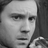

True

In [5]:
all_data = load_df(f"{full_project_dir}/raw_data/fer2013/fer2013.csv")
print(all_data.head())
cv2_imshow(all_data['pixels'][0])
cv.imwrite(f"{full_project_dir}/raw_data/fer_example.png", all_data['pixels'][0])

In [ ]:
train_df = all_data[all_data.Usage == 'Training'].copy()
train_df.head()

,emotion,pixels,Usage
0,0,"[[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, ...",Training
1,0,"[[151, 150, 147, 155, 148, 133, 111, 140, 170,...",Training
2,2,"[[231, 212, 156, 164, 174, 138, 161, 173, 182,...",Training
3,4,"[[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, ...",Training
4,6,"[[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 2...",Training


example of generated variations:


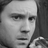

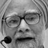

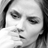

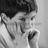

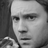

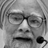

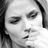

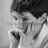

In [ ]:
def augment_data(input_df):
  """
  Takes a dataframe with columns 'emotion' and 'pixels' as input and returns a
  new dataframe with original and flipped images
  """
  flipped_df = input_df.copy()
  flipped_df["pixels"] = flipped_df["pixels"].apply(lambda pix: cv.flip(np.copy(pix), 1))
  return pd.concat([input_df, flipped_df], ignore_index=True)
first_img_df = train_df.iloc[[0, 1, 2, 3], :]
augmented_example = augment_data(first_img_df)
print("example of generated variations:")
for pix in augmented_example["pixels"]:
  cv2_imshow(pix)

In [ ]:
import pkg_resources
haar_xml = pkg_resources.resource_filename(
    'cv2', 'data/haarcascade_frontalface_default.xml')
haar_eye_xml = pkg_resources.resource_filename(
    'cv2', 'data/haarcascade_eye.xml')
i = 0
face_detector = cv.CascadeClassifier(haar_xml)
eye_detector = cv.CascadeClassifier(haar_eye_xml)

def crop_face(pixels, param):
  faces = face_detector.detectMultiScale(pixels, param)
  if len(faces) == 0:
    return pixels, False

  face_x, face_y, face_w, face_h = faces[0]
  return pixels[int(face_y):int(face_y+face_h), int(face_x):int(face_x+face_w)], True

def align_face(orig_pixels, param):
  global i
  i += 1
  if i % 100 == 0:
    print(f"progress: {i}")
  pixels = np.copy(orig_pixels)
  eyes = eye_detector.detectMultiScale(pixels, param)
  if len(eyes) < 2:
    return pixels, False

  eye_1 = eyes[0]
  eye_2 = eyes[1]

  if eye_1[0] < eye_2[0]:
   left_eye = eye_1
   right_eye = eye_2
  else:
   left_eye = eye_2
   right_eye = eye_1
  left_eye_center = (int(left_eye[0] + (left_eye[2] / 2)), int(left_eye[1] + (left_eye[3] / 2)))
  left_eye_x = left_eye_center[0]; left_eye_y = left_eye_center[1]
 
  right_eye_center = (int(right_eye[0] + (right_eye[2]/2)), int(right_eye[1] + (right_eye[3]/2)))
  right_eye_x = right_eye_center[0]; right_eye_y = right_eye_center[1]
  # compute the angle between the eye centroids
  dY = right_eye_center[1] - left_eye_center[1]
  dX = right_eye_center[0] - left_eye_center[0]
  angle = np.degrees(np.arctan2(dY, dX))
  # print(f"dY: {dY}, dX: {dX}, angle: {angle}")
  # cv.circle(pixels, left_eye_center, 2, (255, 0, 0) , 2)
  # cv.circle(pixels, right_eye_center, 2, (255, 0, 0) , 2)
  # cv.line(pixels,right_eye_center, left_eye_center,(67,67,67),2)
  # cv2_imshow(pixels)
  # compute center (x, y)-coordinates (i.e., the median point)
  # between the two eyes in the input image
  eyesCenter = ((left_eye_center[0] + right_eye_center[0]) // 2,
      (left_eye_center[1] + right_eye_center[1]) // 2)
  
  # grab the rotation matrix for rotating and scaling the face
  M = cv.getRotationMatrix2D(eyesCenter, angle, 1)

  return cv.warpAffine(pixels, M, (len(orig_pixels), len(orig_pixels[0])), flags=cv.INTER_CUBIC), True

In [ ]:
# best_faces = 0
# best_faces_eyes = 0
# best_eyes = 0
# best_eyes_faces = 0
# best_faces_params = None
# best_eyes_params = None
# for initial_img_size in ([256]):
#   for crop_to_face_first in (False, True):
#     for rate in (1.01, 1.03):
#       faces = 0
#       eyes = 0
#       for p in augmented_train_df["pixels"]:
#         p = cv.resize(p, (initial_img_size, initial_img_size))
#         p = cv.equalizeHist(p)
#         if crop_to_face_first:
#           p, did_crop = crop_face(p, rate)
#           if did_crop:
#             p = cv.resize(p, (initial_img_size, initial_img_size))
#             faces += 1
#         p, did_align = align_face(p, rate)
#         if did_align:
#           eyes += 1
#         if not crop_to_face_first:
#           p, did_crop = crop_face(p, rate)
#           if did_crop:
#             p = cv.resize(p, (initial_img_size, initial_img_size))
#             faces += 1
#       params = f"{initial_img_size}, {crop_to_face_first}, {rate}"
#       if faces > best_faces:
#         best_faces = faces
#         best_faces_eyes = eyes
#         best_faces_params = params
#       if eyes > best_eyes:
#         best_eyes = eyes
#         best_eyes_faces = faces
#         best_eyes_params = params
#       print(f"{params}: eyes: {eyes}/{len(augmented_train_df)}, faces: {faces}/{len(augmented_train_df)}")
# print(f"best: faces {best_faces}/{len(augmented_train_df)}, eyes {best_faces_eyes} with params {best_faces_params}")
# print(f"best: eyes {best_eyes}/{len(augmented_train_df)}, faces {best_eyes_faces} with params {best_eyes_params}")

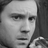

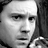

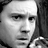

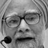

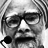

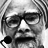

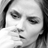

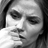

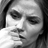

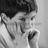

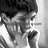

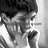

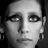

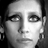

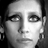

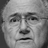

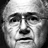

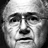

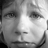

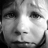

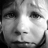

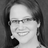

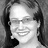

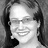

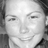

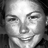

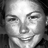

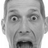

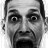

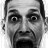

In [ ]:
num_faces_aligned = 0
num_faces_cropped = 0

def preprocess_single_img(orig_pixels, crop_first = False):
  # first blow up image to make eye detection better
  # pixels = cv.resize(orig_pixels, (96, 96))
  # # histogram equalization
  pixels = cv.equalizeHist(orig_pixels)
  # if crop_first:
  #   pixels, was_cropped = crop_face(pixels, 1.02)
  #   pixels = cv.resize(pixels, (96, 96))

  # pixels, was_aligned = align_face(pixels, 1.02)

  # if not crop_first:
  #   pixels, was_cropped = crop_face(pixels, 1.02)
  
  # pixels = cv.resize(pixels, (48, 48))

  # if was_aligned:
  #   global num_faces_aligned
  #   num_faces_aligned += 1
  # if was_cropped:
  #   global num_faces_cropped
  #   num_faces_cropped += 1
  return pixels

for i in range(10):
  cv2_imshow(train_df['pixels'][i])
  cv2_imshow(preprocess_single_img(train_df['pixels'][i]))
  cv2_imshow(preprocess_single_img(train_df['pixels'][i], True))

In [ ]:
val_df = all_data[all_data.Usage == 'PublicTest'].copy()
test_df = all_data[all_data.Usage == 'PrivateTest'].copy()
for df, label in ((train_df, "train"), (val_df, "validation"), (test_df, "testing")):
  num_faces_aligned = 0
  num_faces_cropped = 0
  i = 0
  df["pixels"] = df["pixels"].apply(preprocess_single_img)
  # print(f"Aligned {num_faces_aligned} and cropped {num_faces_cropped} out of {len(df)} from {label} set")

In [ ]:
augmented_train_df = augment_data(train_df)
print(f"Augmented training data from {len(train_df)} to {len(augmented_train_df)} examples")

Augmented training data from 28709 to 57418 examples


In [ ]:
# !mkdir "/content/drive/My Drive/4A/CS486 Project/preprocessed_data/"
def save_to_files(df, prefix):
  X = df["pixels"].to_numpy()
  Y = pd.get_dummies(df['emotion']).values
  np.save(f"{full_project_dir}/preprocessed_data/{prefix}_X", X)
  np.save(f"{full_project_dir}/preprocessed_data/{prefix}_Y", Y)

save_to_files(augmented_train_df, "fer2013_train")
save_to_files(val_df, "fer2013_val")
save_to_files(test_df, "fer2013_test")

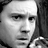

Angry


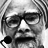

Angry


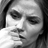

Fear


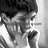

Sad


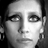

Neutral


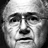

Fear


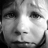

Sad


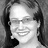

Happy


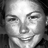

Happy


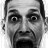

Fear


In [ ]:
# example on how to load images from files
train_X = np.load(f"{full_project_dir}/preprocessed_data/fer2013_train_X.npy", allow_pickle=True)
train_Y = np.load(f"{full_project_dir}/preprocessed_data/fer2013_train_Y.npy", allow_pickle=True)

emotions = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
for i in range(10):
  cv2_imshow(train_X[i])
  print(emotions[np.where(train_Y[i]==1)[0][0]])

In [ ]:
drive.flush_and_unmount()
print('All changes made in this colab session should now be visible in Drive.')

All changes made in this colab session should now be visible in Drive.
